In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from torchvision import models
import torchvision

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# helper function
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


<h1> Prepare Data</h1>

In [22]:
from datasetv2 import datasetv3

batch_size = 128
resize_size = 299
train_loader, test_loader, train_dataset, test_dataset = datasetv3(resize_size)

100%|██████████| 4/4 [00:00<00:00, 474.68it/s]


In [23]:
# dataiter = iter(train_loader)
for i, (images, labels) in enumerate(train_loader):
    break
print(type(images))
print(images.shape)
print(labels.shape)
print(type(train_loader))

<class 'torch.Tensor'>
torch.Size([128, 3, 299, 299])
torch.Size([128])
<class 'torch.utils.data.dataloader.DataLoader'>


Use pretrained inception

In [24]:
model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)


num_epochs = 15

for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i + 1) % 5 == 0:
            print(
                "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"
                % (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            )

Epoch [1/15], lter [5/40] Loss: 1.3735
Epoch [1/15], lter [10/40] Loss: 1.3040
Epoch [1/15], lter [15/40] Loss: 1.2786
Epoch [1/15], lter [20/40] Loss: 1.1834
Epoch [1/15], lter [25/40] Loss: 1.1441
Epoch [1/15], lter [30/40] Loss: 1.1445
Epoch [1/15], lter [35/40] Loss: 1.1149
Epoch [1/15], lter [40/40] Loss: 1.1134
Epoch [2/15], lter [5/40] Loss: 1.0319
Epoch [2/15], lter [10/40] Loss: 1.0664
Epoch [2/15], lter [15/40] Loss: 1.0181
Epoch [2/15], lter [20/40] Loss: 0.9946
Epoch [2/15], lter [25/40] Loss: 0.9656
Epoch [2/15], lter [30/40] Loss: 0.9539
Epoch [2/15], lter [35/40] Loss: 0.9449
Epoch [2/15], lter [40/40] Loss: 0.9245
Epoch [3/15], lter [5/40] Loss: 0.9517
Epoch [3/15], lter [10/40] Loss: 0.9503
Epoch [3/15], lter [15/40] Loss: 0.9360
Epoch [3/15], lter [20/40] Loss: 0.8246
Epoch [3/15], lter [25/40] Loss: 0.9153
Epoch [3/15], lter [30/40] Loss: 0.9175
Epoch [3/15], lter [35/40] Loss: 0.8817
Epoch [3/15], lter [40/40] Loss: 0.9037
Epoch [4/15], lter [5/40] Loss: 0.7449
Epoc

Accuracy of test images: 68.125000 %
Predicted:  Moderate_Demented Mild_Demented Mild_Demented Non_Demented Very_Mild_Demented


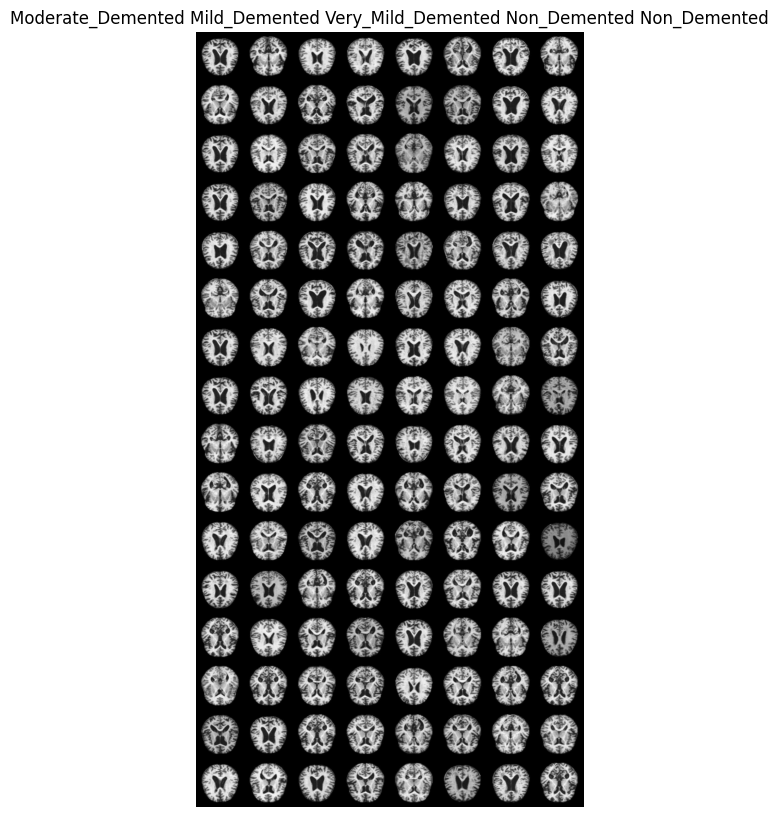

In [26]:
# import ad_labels
# model = torch.load('inceptionv3v3.pt')

LABELS_MAP = {
    "Non_Demented": 0,
    "Very_Mild_Demented": 1,
    "Mild_Demented": 2,
    "Moderate_Demented": 3,
}
LABELS_LIST = [
    "Non_Demented",
    "Very_Mild_Demented",
    "Mild_Demented",
    "Moderate_Demented",
]


model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

print("Accuracy of test images: %f %%" % (100 * float(correct) / total))

classes = LABELS_LIST

test_iterator = iter(test_loader)
images, labels = next(test_iterator)

outputs = model(images.to(device))

_, predicted = torch.max(outputs.data, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(5)))

title = " ".join("%5s" % classes[labels[j]] for j in range(5))
imshow(torchvision.utils.make_grid(images, normalize=True), title)

In [10]:
device

device(type='cuda')

In [11]:
# torch.save(model, 'inceptionv3v4.pt')

v1: lr 1e-3, 10, batch_siz = 128 epochs 58.046875 %
v2: lr 5e-4, 15, batch_siz = 128 epochs 57.968750 %
v3: lr 1e-3, 15, batch_siz = 128 epochs 58.359375 %
v4: lr 1e-3, 15, batch_siz = 64 epochs 58.125000 %
v5: lr 1e-3, 15, batch_siz = 256 epochs 60.468750 %
v6: lr 1e-3, 15, batch_siz = 512 epochs 56.328125 %
